In [53]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib
from tqdm import tqdm
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Simhei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负数坐标显示问题

# **加载原始数据**
X = np.load("X.npy")
y = np.load("y.npy", allow_pickle=True)
y = np.array(y, dtype=str)  # 确保 y 是字符串数组

print(f"类别数据: {np.unique(y)}")  # 检查类别名称

# **划分训练集和测试集**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **训练 One-Class SVM**
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05)

clf.fit(X_train)  # 只训练正常数据

# **保存模型**
joblib.dump(clf, "one_class_svm_model.pkl")
print("模型训练完成！")

# **降维用于可视化**
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# **生成 500 个随机陌生样本**
num_novel_samples = 500
X_outliers = np.random.uniform(-1, 1, (num_novel_samples, X.shape[1]))  # 生成随机陌生样本
X_outliers_pca = pca.transform(X_outliers)

# **预测**
y_pred_train = clf.predict(X_train)  # 训练数据预测
y_pred_test = clf.predict(X_test)  # 测试数据预测
y_pred_outliers = clf.predict(X_outliers)  # 陌生样本预测

# **生成网格**
xx, yy = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
print("Step 1: 创建网格.")

# **计算决策边界**
Z = np.zeros(xx.shape).ravel()
for i, (x, yy_grid) in enumerate(tqdm(np.c_[xx.ravel(), yy.ravel()], desc="计算决策边界")):
    Z[i] = clf.decision_function(pca.inverse_transform([[x, yy_grid]]))[0]
Z = Z.reshape(xx.shape)
print("Step 2: 计算决策边界完成.")

类别数据: ['1电抗器正常' '2局部放电' '3铁芯松动' '4直流偏磁' '5重过载' '6组件松动']
模型训练完成！
Step 1: 创建网格.


计算决策边界: 100%|██████████| 40000/40000 [13:51<00:00, 48.08it/s]

Step 2: 计算决策边界完成.


Step 3: 绘制决策区域 (Z >= 0).
Step 5: 绘制数据点.


OSError: [Errno 22] Invalid argument: 'F:\\PycharmProjects\\gihub\\2025年\\1.29\\新奇svm\\novelty_detection_plot.png'

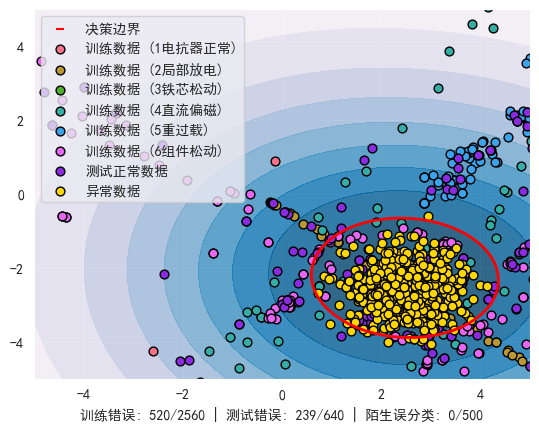

In [106]:
plt.xlim(-5, 5)  # 手动设置X轴范围
plt.ylim(-5, 5)  # 手动设置Y轴范围

# **确保 levels 参数递增**
if Z.min() < 0 and Z.max() > 0:
    # Z的范围跨越0，绘制决策区域
    levels = np.linspace(Z.min(), 0, 7)
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu, alpha=0.6)
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred', alpha=0.3)
    print("Step 3: 绘制决策区域.")

elif Z.min() >= 0:
    # Z的最小值大于等于0
    levels = np.linspace(0, Z.max(), 10)  # 增加levels的细分
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu, alpha=0.8)
    print("Step 3: 绘制决策区域 (Z >= 0).")

else:
    # Z的最大值小于0
    levels = np.linspace(Z.min(), Z.max(), 5)
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu, alpha=0.8)
    print("Step 3: 绘制决策区域 (Z <= 0).")

colors = [(1, 1, 1, 0) for _ in range(len(levels))]  # 默认透明
colors[8] = 'red'  # 将第二个等高线设为红色

# 绘制等高线，第一个为红色，其他透明
plt.contour(xx, yy, Z, levels=levels, linewidths=2, colors=colors)

plt.scatter([], [], c='red', marker='_', label="决策边界 ")
# **自动分配类别颜色**
unique_labels = np.unique(y_train)  # 仅使用训练数据的类别
palette = sns.color_palette("husl", len(unique_labels))  # 生成颜色
label_color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

# **绘制训练数据**
s = 40
for label in unique_labels:
    indices = y_train == label
    plt.scatter(X_pca_train[indices, 0], X_pca_train[indices, 1],
                c=[label_color_map[label]], s=s, edgecolors='k', label=f"训练数据 ({label})")

# **绘制测试数据**
plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c='blueviolet', s=s, edgecolors='k', label="测试正常数据")

# **绘制陌生样本**
plt.scatter(X_outliers_pca[:, 0], X_outliers_pca[:, 1], c='gold', s=s, edgecolors='k', label="异常数据")
print("Step 5: 绘制数据点.")

# **统计误分类样本数**
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# **添加误分类信息**
plt.xlabel(f"训练错误: {n_error_train}/{len(X_train)} | 测试错误: {n_error_test}/{len(X_test)} | 陌生误分类: {n_error_outliers}/{len(X_outliers)}")

# **优化图例**
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(loc="upper left", fontsize=10, frameon=True)

# **保存图像**
output_path = "novelty_detection_plot.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"Step 6: 图像已保存到 {output_path}.")

# **显示图**
plt.show()
print("Step 7: 图像已显示.")

ValueError: Contour levels must be increasing

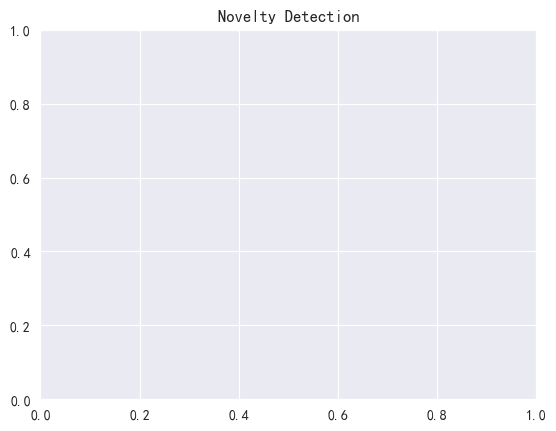

In [90]:
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)  #绘制异常区域的轮廓， 把异常区域划分为7个层次
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # 绘制轮廓，SVM的边界点（到边界距离为0的点
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')  # 绘制正常样本的区域，使用带有填充的轮廓